In [ ]:
# Imports
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import timm
import torch.nn as nn




In [ ]:
# Label mapping
label_to_id = {'TVMA': 0, 'TVFOURTEEN': 1, 'TVYSEVEN': 2, 'Non-Profane': 3}
id_to_label = {v: k for k, v in label_to_id.items()}

# Load and extend label map with non-profane
csv_path = "/Users/raj/Downloads/classtapad.csv"
df = pd.read_csv(csv_path)
df = df.dropna()
df["Word"] = df["Word"].str.strip()
df["Class"] = df["Class"].str.strip()
label_map = dict(zip(df["Word"] + ".mp3", df["Class"]))

non_profane_dir = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Tapad/newaudio/non_profane"
for f in glob.glob(os.path.join(non_profane_dir, "*.mp3")):
    fname = os.path.basename(f)
    if fname not in label_map:
        label_map[fname] = "Non-Profane"


In [ ]:

#  Mel transforms
mel_transform = MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=320,
    n_mels=128,
)
db_transform = AmplitudeToDB(top_db=80)


In [ ]:

#  Dataset
class WordAudioDataset(Dataset):
    def __init__(self, audio_dir, label_map, transform=None):
        self.audio_dir = audio_dir
        self.label_map = label_map
        self.transform = transform
        self.label_to_id = label_to_id

        all_audio_files = glob.glob(os.path.join(audio_dir, "**/*.mp3"), recursive=True)
        self.files = [f for f in all_audio_files if os.path.basename(f) in label_map]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        attempts = 0
        while attempts < 10:
            try:
                path = self.files[idx]
                if not os.path.exists(path):
                    raise FileNotFoundError(f"Missing: {path}")
                filename = os.path.basename(path)
                label = self.label_to_id[self.label_map[filename]]
                waveform, sr = torchaudio.load(path)

                if waveform.shape[1] < 16000:
                    waveform = F.pad(waveform, (0, 16000 - waveform.shape[1]))
                else:
                    waveform = waveform[:, :16000]

                mel = self.transform(waveform)
                mel = db_transform(mel)
                mel = torch.nn.functional.interpolate(mel.unsqueeze(0), size=(224, 224), mode="bilinear").squeeze(0)

                return mel, label
            except Exception as e:
                print(f"\u26a0\ufe0f Skipping sample {idx}: {e}")
                idx = (idx + 1) % len(self.files)
                attempts += 1

        raise RuntimeError("Too many consecutive loading failures.")


In [ ]:

# Dataset path
audio_dir = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Tapad/newaudio"
dataset = WordAudioDataset(audio_dir, label_map, transform=mel_transform)



In [ ]:
#  Stratified split
from sklearn.model_selection import train_test_split
indices = list(range(len(dataset)))
labels = [dataset[i][1] for i in indices]
train_idx, val_idx = train_test_split(indices, stratify=labels, test_size=0.2, random_state=42)

train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=16, shuffle=True)
val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=16, shuffle=False)



In [ ]:
#  Model
model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.patch_embed.proj = nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
model.head = nn.Linear(model.head.in_features, len(label_to_id))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=F

In [ ]:
#  Class weights
all_labels = [dataset[i][1] for i in range(len(dataset))]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


In [ ]:

#  Training setup
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
from collections import Counter

label_counter = Counter()
for i in range(len(dataset)):
    try:
        _, label = dataset[i]
        label_counter[label] += 1
    except:
        continue

print(f"\n Total samples in dataset: {len(dataset)}\n")
print(" Samples per class:")
for label_id, count in sorted(label_counter.items()):
    label_name = id_to_label[label_id]
    print(f"  {label_name:12} → {count} samples")


📦 Total samples in dataset: 3839

📊 Samples per class:
  TVMA         → 1027 samples
  TVFOURTEEN   → 527 samples
  TVYSEVEN     → 140 samples
  Non-Profane  → 2145 samples


In [ ]:
# 5. Train and Evaluate

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

best_acc = 0
num_epochs = 50  
early_stop_patience = 5
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for mel, label in train_loader:
        mel, label = mel.to(device), label.to(device)

        optimizer.zero_grad()
        # Fixed shape error by ensuring [B, 1, 224, 224]
        mel = mel.unsqueeze(1) if mel.dim() == 3 else mel  # [B, 1, H, W]
        output = model(mel)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Evaluation
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for mel, label in val_loader:
            mel, label = mel.to(device), label.to(device)
            mel = mel.unsqueeze(1) if mel.dim() == 3 else mel
            output = model(mel)

            probs = torch.softmax(output, dim=1).cpu().numpy()
            preds = torch.argmax(output, dim=1).cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(label.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    try:
        auc = roc_auc_score(label_binarize(all_labels, classes=list(id_to_label.keys())), all_probs, multi_class='ovr') * 100
        auc_str = f"{auc:.2f}"
    except:
        auc_str = "N/A"

    print(f"\n Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Acc: {acc:.2f}% | AUC: {auc_str}")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_astv2_wordlevel.pth")
        print(f" Saved best model with accuracy: {round(best_acc, 2)}%")
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= early_stop_patience:
        print(" Early stopping triggered.")
        break

    scheduler.step()


📊 Epoch 01 | Loss: 1.6321 | Acc: 36.85% | AUC: 77.78
✅ Saved best model with accuracy: 36.85%

📊 Epoch 02 | Loss: 1.2062 | Acc: 65.49% | AUC: 86.31
✅ Saved best model with accuracy: 65.49%

📊 Epoch 03 | Loss: 1.0210 | Acc: 68.23% | AUC: 86.73
✅ Saved best model with accuracy: 68.23%

📊 Epoch 04 | Loss: 0.9616 | Acc: 69.01% | AUC: 87.07
✅ Saved best model with accuracy: 69.01%

📊 Epoch 05 | Loss: 0.8655 | Acc: 73.31% | AUC: 88.95
✅ Saved best model with accuracy: 73.31%

📊 Epoch 06 | Loss: 0.7643 | Acc: 69.27% | AUC: 87.67

📊 Epoch 07 | Loss: 0.7417 | Acc: 58.98% | AUC: 85.33

📊 Epoch 08 | Loss: 0.6276 | Acc: 67.97% | AUC: 87.82

📊 Epoch 09 | Loss: 0.5868 | Acc: 64.84% | AUC: 85.67

📊 Epoch 10 | Loss: 0.4395 | Acc: 71.74% | AUC: 89.07
⏹️ Early stopping triggered.


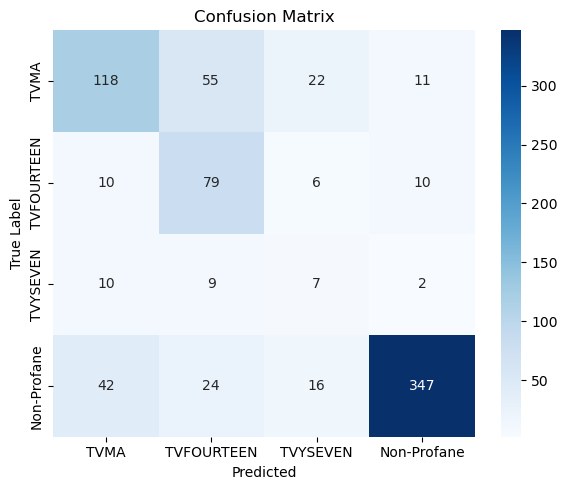

In [ ]:
# 6. Visualize Confusion Matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id_to_label[i] for i in range(len(id_to_label))],
            yticklabels=[id_to_label[i] for i in range(len(id_to_label))])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
#  5. Train and Evaluate with Augmentation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import torchaudio
import random
import torch.nn.functional as F

# Augmentations: Time/Frequency masking, pitch shift, noise injection
def augment_waveform(mel):
    # Time and frequency masking
    mel = torchaudio.transforms.FrequencyMasking(freq_mask_param=15)(mel)
    mel = torchaudio.transforms.TimeMasking(time_mask_param=35)(mel)

    # Add random pitch shift
    if random.random() < 0.3:
        shift = random.uniform(-1.5, 1.5)
        mel = mel + shift

    # Add low Gaussian noise
    if random.random() < 0.3:
        noise = 0.005 * torch.randn_like(mel)
        mel = mel + noise

    return mel

best_acc = 0
num_epochs = 50 
early_stop_patience = 20
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for mel, label in train_loader:
        mel, label = mel.to(device), label.to(device)

        # Apply augmentation only during training
        mel = augment_waveform(mel)

        optimizer.zero_grad()
        # Fixed shape error by ensuring [B, 1, 224, 224]
        mel = mel.unsqueeze(1) if mel.dim() == 3 else mel  # [B, 1, H, W]
        output = model(mel)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Evaluation
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for mel, label in val_loader:
            mel, label = mel.to(device), label.to(device)
            mel = mel.unsqueeze(1) if mel.dim() == 3 else mel
            output = model(mel)

            probs = torch.softmax(output, dim=1).cpu().numpy()
            preds = torch.argmax(output, dim=1).cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(label.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    try:
        auc = roc_auc_score(label_binarize(all_labels, classes=list(id_to_label.keys())), all_probs, multi_class='ovr') * 100
        auc_str = f"{auc:.2f}"
    except:
        auc_str = "N/A"

    print(f"\n Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Acc: {acc:.2f}% | AUC: {auc_str}")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_astv2_augmentedv2.pth")
        print(f" Saved best model with accuracy: {round(best_acc, 2)}%")
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= early_stop_patience:
        print(" Early stopping triggered.")
        break

    scheduler.step()





📊 Epoch 01 | Loss: 0.2078 | Acc: 79.04% | AUC: 89.99
✅ Saved best model with accuracy: 79.04%

📊 Epoch 02 | Loss: 0.1935 | Acc: 74.87% | AUC: 90.98

📊 Epoch 03 | Loss: 0.2388 | Acc: 70.96% | AUC: 87.93

📊 Epoch 04 | Loss: 0.1216 | Acc: 78.39% | AUC: 90.45

📊 Epoch 05 | Loss: 0.0889 | Acc: 77.73% | AUC: 90.20

📊 Epoch 06 | Loss: 0.1306 | Acc: 78.12% | AUC: 89.90

📊 Epoch 07 | Loss: 0.0882 | Acc: 77.60% | AUC: 90.71

📊 Epoch 08 | Loss: 0.0851 | Acc: 79.04% | AUC: 89.54

📊 Epoch 09 | Loss: 0.0698 | Acc: 78.52% | AUC: 90.18

📊 Epoch 10 | Loss: 0.0828 | Acc: 78.26% | AUC: 90.36

📊 Epoch 11 | Loss: 0.0822 | Acc: 78.91% | AUC: 90.80

📊 Epoch 12 | Loss: 0.1076 | Acc: 77.86% | AUC: 90.03

📊 Epoch 13 | Loss: 0.0933 | Acc: 77.08% | AUC: 90.64

📊 Epoch 14 | Loss: 0.0624 | Acc: 79.69% | AUC: 90.49
✅ Saved best model with accuracy: 79.69%

📊 Epoch 15 | Loss: 0.0505 | Acc: 79.95% | AUC: 90.48
✅ Saved best model with accuracy: 79.95%

📊 Epoch 16 | Loss: 0.0546 | Acc: 78.39% | AUC: 90.85

📊 Epoch 17 |

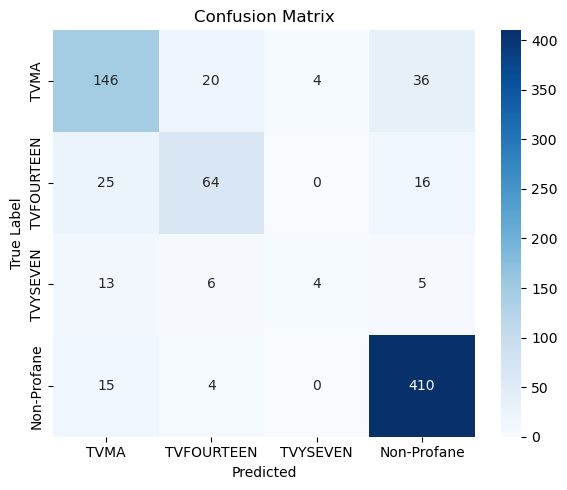

In [ ]:
#  6. Visualize Confusion Matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id_to_label[i] for i in range(len(id_to_label))],
            yticklabels=[id_to_label[i] for i in range(len(id_to_label))])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Ready for Testing or Deployment

In [52]:
print(classification_report(all_labels, all_preds, target_names=[id_to_label[i] for i in range(len(id_to_label))]))

              precision    recall  f1-score   support

        TVMA       0.73      0.71      0.72       206
  TVFOURTEEN       0.68      0.61      0.64       105
    TVYSEVEN       0.50      0.14      0.22        28
 Non-Profane       0.88      0.96      0.92       429

    accuracy                           0.81       768
   macro avg       0.70      0.60      0.63       768
weighted avg       0.80      0.81      0.80       768



In [ ]:


# 7. Inference on Test Audio

import torchaudio
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio

# Load trained model
model.load_state_dict(torch.load("best_astv2_augmentedv2.pth", map_location=device))
model.eval().to(device)

# Parameters
sample_rate = 16000

# Prediction function
def predict_on_audio(file_path, model, mel_transform, db_transform, device,
                     window_sec=0.5, stride_sec=0.25, threshold=0.5):
    waveform, sr = torchaudio.load(file_path)
    waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
    waveform = waveform.mean(dim=0, keepdim=True)

    window_samples = int(window_sec * sample_rate)
    stride_samples = int(stride_sec * sample_rate)
    total_samples = waveform.shape[1]

    predictions, segments, confidences = [], [], []

    for start in range(0, total_samples - window_samples + 1, stride_samples):
        end = start + window_samples
        segment = waveform[:, start:end]
        if segment.shape[1] < window_samples:
            segment = torch.nn.functional.pad(segment, (0, window_samples - segment.shape[1]))

        with torch.no_grad():
            mel = mel_transform(segment)
            mel_db = db_transform(mel)
            mel_db = mel_db.unsqueeze(0)  # [1, 1, Freq, Time]

            if mel_db.shape[-1] < 10 or mel_db.shape[-2] < 10:
                continue

            mel_resized = torch.nn.functional.interpolate(
                mel_db, size=(224, 224), mode='bilinear', align_corners=False
            ).to(device)

            out = torch.softmax(model(mel_resized), dim=1)
            pred_label = torch.argmax(out, dim=1).item()
            confidence = out[0, pred_label].item()

            predictions.append(pred_label if confidence >= threshold else None)
            confidences.append(confidence if confidence >= threshold else None)
            segments.append((start, end))

    return waveform.squeeze().numpy(), segments, predictions, confidences



In [1]:

import torchaudio
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio

# Load trained model
model.load_state_dict(torch.load("best_astv2_augmented.pth", map_location=device))
model.eval().to(device)

# Parameters
sample_rate = 16000

# Prediction function with confidence + energy filtering
def predict_on_audio(file_path, model, mel_transform, db_transform, device,
                     window_sec=0.5, stride_sec=0.25, threshold=0.7, energy_thresh=0.001):
    waveform, sr = torchaudio.load(file_path)
    waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
    waveform = waveform.mean(dim=0, keepdim=True)

    window_samples = int(window_sec * sample_rate)
    stride_samples = int(stride_sec * sample_rate)
    total_samples = waveform.shape[1]

    predictions, segments, confidences = [], [], []

    for start in range(0, total_samples - window_samples + 1, stride_samples):
        end = start + window_samples
        segment = waveform[:, start:end]
        if segment.shape[1] < window_samples:
            segment = torch.nn.functional.pad(segment, (0, window_samples - segment.shape[1]))

        energy = segment.pow(2).mean().item()
        if energy < energy_thresh:
            continue

        with torch.no_grad():
            mel = mel_transform(segment)
            mel_db = db_transform(mel)
            mel_db = mel_db.unsqueeze(0)

            if mel_db.shape[-1] < 10 or mel_db.shape[-2] < 10:
                continue

            mel_resized = torch.nn.functional.interpolate(
                mel_db, size=(224, 224), mode='bilinear', align_corners=False
            ).to(device)

            out = torch.softmax(model(mel_resized), dim=1)
            pred_label = torch.argmax(out, dim=1).item()
            confidence = out[0, pred_label].item()

            if confidence < threshold:
                predictions.append(None)
                confidences.append(None)
            else:
                predictions.append(pred_label)
                confidences.append(confidence)

            segments.append((start, end))

    return waveform.squeeze().numpy(), segments, predictions, confidences

NameError: name 'model' is not defined

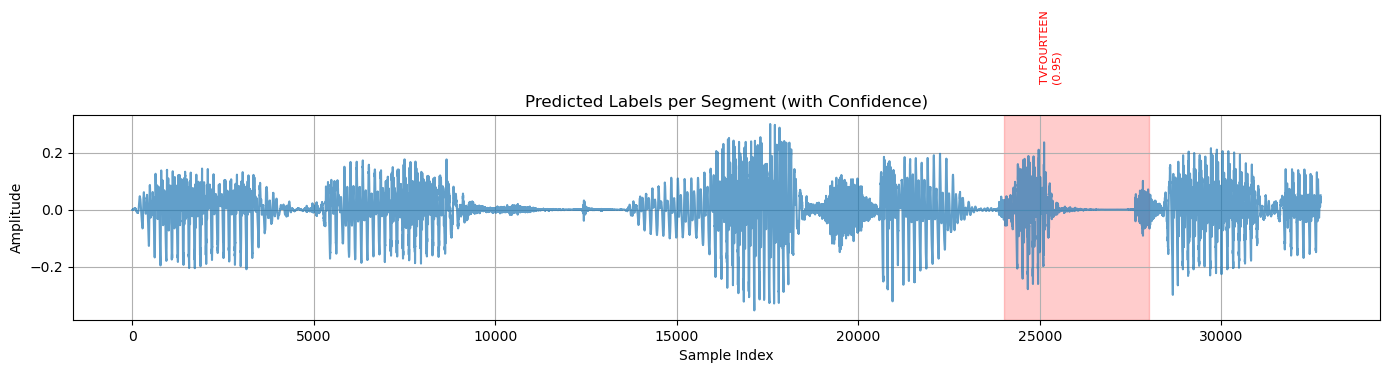

In [120]:
# Example file

audio_path = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/mutox/Tanvir/0eca4d8c0f6ccfc3e92c9398_3218400_3220446.mp3"

waveform_np, segments, predictions, confidences = predict_on_audio(
    file_path=audio_path,
    model=model,
    mel_transform=mel_transform,
    db_transform=db_transform,
    device=device,
    window_sec=0.25,
    stride_sec=0.5,
    threshold=0.94
)

plt.figure(figsize=(14, 4))
plt.plot(waveform_np, alpha=0.7)
for (start, end), label_id, conf in zip(segments, predictions, confidences):
    if label_id is not None:
        label = id_to_label[label_id]
        if label != "Non-Profane":
            plt.axvspan(start, end, color='red', alpha=0.2)
            label_text = f"{label}\n({conf:.2f})"
            plt.text(start + 1000, 0.45, label_text, color='red', fontsize=8, rotation=90)

plt.title("Predicted Labels per Segment (with Confidence)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

Audio(audio_path)


In [121]:
def apply_beep_on_predictions(waveform, sample_rate, segments, predictions, labels_to_beep):
    beep = torch.sin(2 * torch.pi * torch.arange(0, 0.5 * sample_rate) * 1000 / sample_rate)
    beep = beep.unsqueeze(0)
    waveform = waveform.clone()

    for (start, end), pred in zip(segments, predictions):
        if pred is None:
            continue
        label = id_to_label[pred]
        if label in labels_to_beep:
            duration = end - start
            beep_resized = F.interpolate(beep.unsqueeze(0), size=duration, mode="linear").squeeze(0)
            waveform[:, start:end] = beep_resized[:, :duration]
    return waveform

labels_to_beep = ["TVMA", "TVFOURTEEN", "TVYSEVEN"]
waveform_tensor = torch.tensor(waveform_np).unsqueeze(0)

beeped_waveform = apply_beep_on_predictions(waveform_tensor, sample_rate, segments, predictions, labels_to_beep)

output_path = "beeped_output123.wav"
torchaudio.save(output_path, beeped_waveform, sample_rate)
print(f"Saved to: {output_path}")

Audio(output_path)

Saved to: beeped_output123.wav
